In [4]:
library(ggplot2)
library(ggdist)
library(patchwork)
library(tidyr)
library(dplyr)
library(glmmTMB)
library(emmeans)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'



In [5]:
# --- Load Data ------------------------------------------------------------------
data <- read.csv("data/fullResults.csv", header = TRUE)

# Create binary anchor and alignment labels
data <- data %>%
  mutate(
    anchor = ifelse(anchorCategory == "anchor", "anchor", "non-anchor"),
    alignment = ifelse(alignmentCategory == "aligned", "aligned", "unaligned")
  )

# Create anchorType (special anchors 25 and 50)
data <- data %>%
  mutate(anchorType = case_when(
    selectedPart == 25 ~ "25",
    selectedPart == 50 ~ "50",
    TRUE ~ "non-anchor"
  ))

# Factorize main grouping variables
data$alignment <- factor(data$alignment, levels = c("aligned", "unaligned"))
data$anchor <- factor(data$anchor, levels = c("anchor", "non-anchor"))
data$chartType <- factor(data$chartType, levels = c("pie", "line"))

# Relabel factor levels for pretty plotting
levels(data$alignment) <- c("Aligned", "Unaligned")
levels(data$anchor) <- c("Anchor", "Non-Anchor")
levels(data$chartType) <- c("Pie", "Stacked Bar")

# Create numeric contrast-coded variables for modeling
data <- data %>%
  mutate(
    alignment_num = ifelse(alignment == "Aligned", -1, 1),
    anchor_num = ifelse(anchor == "Anchor", -1, 1),
    chartType_num = ifelse(chartType == "Pie", -1, 1)
  )

# Factorize detailed categories (alignmentCategory, anchorCategory)
data$alignmentCategory <- factor(data$alignmentCategory, levels = c("aligned", "near-aligned", "far-from-aligned"))
levels(data$alignmentCategory) <- c("Aligned", "Near Aligned", "Far from Aligned")

data$anchorCategory <- factor(data$anchorCategory, levels = c("anchor", "near-anchor", "far-anchor"))
levels(data$anchorCategory) <- c("Anchor", "Near Anchor", "Far from Anchor")

# Calculate rounding variables
data$distToNearest5 <- abs(data$selectedPart - round(data$selectedPart / 5) * 5)
data$distToNearest10 <- abs(data$selectedPart - round(data$selectedPart / 10) * 10)

In [6]:
# --- Define Constants ---------------------------------------------------------
blue <- "#336199"
lightblue <- "#5688C7"
red <- "#E74236"
lightred <- "#EE766D"
green <- "#00A35F"
lightgreen <- "#0ACC7B"

lisAbsError <- c(-0.5, 10.5)
size <- 0.5
baseSize <- 22
timeLims = c(0, 15)
errorLims = c(-0.5, 10.5)

breaksAbsError <- seq(floor(min(data$absError)) - 0.5, ceiling(max(data$absError)) + 0.5, by = 1)

In [7]:
# --- Build Accuracy Model --------------------------------------------------------------
modelAccuracy <- glmmTMB(
  absError ~ chartType_num * anchor_num * alignment_num +
    (1 + anchor_num + alignment_num + chartType_num | userID),
  data = data,
  family = nbinom2(link = "log")
)
summary(modelAccuracy)

 Family: nbinom2  ( log )
Formula:          absError ~ chartType_num * anchor_num * alignment_num + (1 +  
    anchor_num + alignment_num + chartType_num | userID)
Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
  23202.9   23328.9  -11582.5   23164.9      5593 

Random effects:

Conditional model:
 Groups Name          Variance Std.Dev. Corr              
 userID (Intercept)   0.49225  0.7016                     
        anchor_num    0.13723  0.3704   -0.92             
        alignment_num 0.01488  0.1220   -0.69  0.52       
        chartType_num 0.01849  0.1360    0.18 -0.19 -0.35 
Number of obs: 5612, groups:  userID, 60

Dispersion parameter for nbinom2 family (): 1.89 

Conditional model:
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                             0.266751   0.097208   2.744  0.00607
chartType_num                           0.041128   0.034461   1.193  0.23269
anchor_num                              0.64368

In [8]:
# --- Build Speed Model --------------------------------------------------------------
modelSpeed <- glmmTMB(
  responseTime ~ chartType_num * anchor_num * alignment_num +
    (1 + anchor_num + alignment_num + chartType_num | userID),
  data = data,
  family = Gamma(link = "log")
)
summary(modelSpeed)

 Family: Gamma  ( log )
Formula:          
responseTime ~ chartType_num * anchor_num * alignment_num + (1 +  
    anchor_num + alignment_num + chartType_num | userID)
Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
  27055.1   27181.1  -13508.5   27017.1      5593 

Random effects:

Conditional model:
 Groups Name          Variance  Std.Dev. Corr              
 userID (Intercept)   0.1248288 0.35331                    
        anchor_num    0.0019921 0.04463   0.12             
        alignment_num 0.0007469 0.02733   0.31 -0.44       
        chartType_num 0.0033118 0.05755   0.16  0.35  0.04 
Number of obs: 5612, groups:  userID, 60

Dispersion estimate for Gamma family (sigma^2): 0.147 

Conditional model:
                                         Estimate Std. Error z value Pr(>|z|)
(Intercept)                             1.8728939  0.0463525   40.41  < 2e-16
chartType_num                           0.0008645  0.0110938    0.08  0.93788
anchor_num                     

In [9]:
# --- Predict from Model -------------------------------------------------------
predsAccuracy <- emmeans(modelAccuracy, ~ alignment_num * anchor_num * chartType_num)
predsSpeed <- emmeans(modelSpeed, ~ alignment_num * anchor_num * chartType_num)

# Extract pairwise comparison results
contrasts <- as.data.frame(pairs(predsSpeed))

# Clean contrast labels for clarity
contrasts$contrast <- gsub("alignment_num-1", "Aligned", contrasts$contrast)
contrasts$contrast <- gsub("alignment_num1", "Unaligned", contrasts$contrast)
contrasts$contrast <- gsub("anchor_num-1", "Anchor", contrasts$contrast)
contrasts$contrast <- gsub("anchor_num1", "Non-Anchor", contrasts$contrast)
contrasts$contrast <- gsub("chartType_num-1", "Pie", contrasts$contrast)
contrasts$contrast <- gsub("chartType_num1", "Stacked Bar", contrasts$contrast)

contrasts$significance <- ifelse(contrasts$p.value < 0.05, "Significant", "Not Significant")

contrasts

# options(repr.plot.width = 18, repr.plot.height = 20)
# # Plotting the estimates with confidence intervals
# ggplot(contrasts, aes(x = contrast, y = estimate)) +
#   geom_point(size = 3, color = blue) +  # Plot the estimates
#   geom_errorbar(aes(ymin = estimate - 1.96 * SE, ymax = estimate + 1.96 * SE), 
#                 width = 0.2, color = "red") +  # Add 95% CI
#   labs(x = "Contrast", y = "Estimate (Log-Scale Difference)") +
#   theme(axis.text.x = element_text(angle = 90, hjust = 1),  # Rotate x-axis labels
#         axis.title = element_text(size = 14),  # Larger axis titles
#         plot.title = element_text(size = 16, face = "bold")) +  # Title styling
#   ggtitle("Pairwise Contrast Differences (with 95% CI)")  # Add title

,contrast,estimate,SE,df,z.ratio,p.value,significance
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,(Aligned Anchor Pie) - (Unaligned Anchor Pie),-9.970919e-02,0.04374501,Inf,-2.2793272870,3.049647e-01,Not Significant
2,(Aligned Anchor Pie) - (Aligned Non-Anchor Pie),-2.485387e-01,0.04003074,Inf,-6.2086964701,1.493713e-08,Significant
3,(Aligned Anchor Pie) - (Unaligned Non-Anchor Pie),-2.973490e-01,0.03785135,Inf,-7.8557021943,2.288170e-13,Significant
4,(Aligned Anchor Pie) - (Aligned Anchor Stacked Bar),3.941466e-02,0.05192751,Inf,0.7590322878,9.950529e-01,Not Significant
5,(Aligned Anchor Pie) - (Unaligned Anchor Stacked Bar),-1.336176e-01,0.04630686,Inf,-2.8854815843,7.548990e-02,Not Significant
6,(Aligned Anchor Pie) - (Aligned Non-Anchor Stacked Bar),-2.609785e-01,0.04407789,Inf,-5.9208472754,8.943442e-08,Significant
7,(Aligned Anchor Pie) - Unaligned Non-Anchor Stacked Bar,-2.973317e-01,0.04220924,Inf,-7.0442316854,5.226131e-11,Significant
8,(Unaligned Anchor Pie) - (Aligned Non-Anchor Pie),-1.488295e-01,0.03322083,Inf,-4.4800068772,2.007851e-04,Significant
9,(Unaligned Anchor Pie) - (Unaligned Non-Anchor Pie),-1.976398e-01,0.02889210,Inf,-6.8406159492,2.207655e-10,Significant


In [10]:
# Define the plot function based on model predictions
create_model_error_plot <- function(model, data, group_var, title, y_label) {

  # Generate predictions from the model (type = "response" for predicted means)
  predictions <- predict(model, newdata = data, type = "response", se.fit = TRUE)
  
  # Add predictions and standard errors to the data
  data$predicted <- predictions$fit
  data$se_predicted <- predictions$se.fit
  
  # Calculate 95% confidence intervals (CI)
  data$ci_low <- data$predicted - 1.96 * data$se_predicted
  data$ci_high <- data$predicted + 1.96 * data$se_predicted
  
  # Summarize per-user means based on model predictions
  userMeans <- data %>%
    group_by(userID, !!sym(group_var)) %>%
    summarise(
      meanAbsError = mean(predicted, na.rm = TRUE),
      .groups = "drop"
    )

  # Summarize overall means and 95% confidence intervals for interaction
  overallMeans <- userMeans %>%
    group_by(!!sym(group_var)) %>%
    summarise(
      overallMean = mean(meanAbsError, na.rm = TRUE),
      se = sd(meanAbsError, na.rm = TRUE) / sqrt(n()),
      .groups = "drop"
    ) %>%
    mutate(
      ci_low = overallMean - 1.96 * se,
      ci_high = overallMean + 1.96 * se
    )

  # Reshape for parallel coordinates plot
  wide_data <- userMeans %>%
    pivot_wider(names_from = !!sym(group_var), values_from = meanAbsError)
  
  long_data <- wide_data %>%
    pivot_longer(cols = -userID, names_to = group_var, values_to = "meanAbsError")
  
  # Set consistent factor levels
  group_levels <- unique(long_data[[group_var]])
  long_data[[group_var]] <- factor(long_data[[group_var]], levels = group_levels)
  overallMeans[[group_var]] <- factor(overallMeans[[group_var]], levels = group_levels)
  
  # Create the plot based on model predictions
  plot <- ggplot(long_data, aes(x = !!sym(group_var), y = meanAbsError, group = userID)) +
    coord_cartesian(ylim = c(0, 7)) +

    
    # 95% Confidence interval error bars based on model predictions
    geom_errorbar(
      data = overallMeans,
      aes(x = !!sym(group_var), ymin = ci_low, ymax = ci_high),
      width = 0.2,  # Control the width of the error bars
      color = "green",
      linewidth = 1.2,
      inherit.aes = FALSE
    ) +
    
    # Overall mean line and points based on model predictions
    geom_line(
      data = overallMeans,
      aes(x = !!sym(group_var), y = overallMean, group = 1),
      color = "green", linewidth = 1.2,
      inherit.aes = FALSE
    ) +
    geom_point(
      data = overallMeans,
      aes(x = !!sym(group_var), y = overallMean),
      color = "green", size = 3,
      inherit.aes = FALSE
    ) +
    
    theme_minimal(base_size = 14) +
    labs(
      title = title,
      x = group_var,
      y = y_label
    )
  
  return(plot)
}


In [11]:
# Define the plot function
create_error_plot <- function(data, group_var, title, y_label) {
  
  # Summarize per-user means
  userMeans <- data %>%
    group_by(userID, !!sym(group_var)) %>%
    summarise(
      meanAbsError = mean(absError, na.rm = TRUE),
      .groups = "drop"
    )
  
  # Summarize overall means and 95% confidence intervals
  overallMeans <- userMeans %>%
    group_by(!!sym(group_var)) %>%
    summarise(
      overallMean = mean(meanAbsError, na.rm = TRUE),
      se = sd(meanAbsError, na.rm = TRUE) / sqrt(n()),
      .groups = "drop"
    ) %>%
    mutate(
      ci_low = overallMean - 1.96 * se,
      ci_high = overallMean + 1.96 * se
    )
  
  # Reshape for parallel coordinates plot
  wide_data <- userMeans %>%
    pivot_wider(names_from = !!sym(group_var), values_from = meanAbsError)
  
  long_data <- wide_data %>%
    pivot_longer(cols = -userID, names_to = group_var, values_to = "meanAbsError")
  
  # Set consistent factor levels
  group_levels <- unique(long_data[[group_var]])
  long_data[[group_var]] <- factor(long_data[[group_var]], levels = group_levels)
  overallMeans[[group_var]] <- factor(overallMeans[[group_var]], levels = group_levels)
  
  # Create the plot
  plot <- ggplot(long_data, aes(x = !!sym(group_var), y = meanAbsError, group = userID)) +
    coord_cartesian(ylim = c(0, 5)) +
    
    # 95% Confidence interval error bars
    geom_errorbar(
      data = overallMeans,
      aes(x = !!sym(group_var), ymin = ci_low, ymax = ci_high),
      width = 0.2,  # Control the width of the error bars
      color = green,
      linewidth = 1.2,
      inherit.aes = FALSE
    ) +
    
    # Overall mean line and points
    geom_line(
      data = overallMeans,
      aes(x = !!sym(group_var), y = overallMean, group = 1),
      color = green, linewidth = 1.2,
      inherit.aes = FALSE
    ) +
    geom_point(
      data = overallMeans,
      aes(x = !!sym(group_var), y = overallMean),
      color = green, size = 3,
      inherit.aes = FALSE
    ) +
    
    theme_minimal(base_size = baseSize) +
    labs(
      x = title,
      y = y_label
    )
  
  return(plot)
}

pdf 
  2

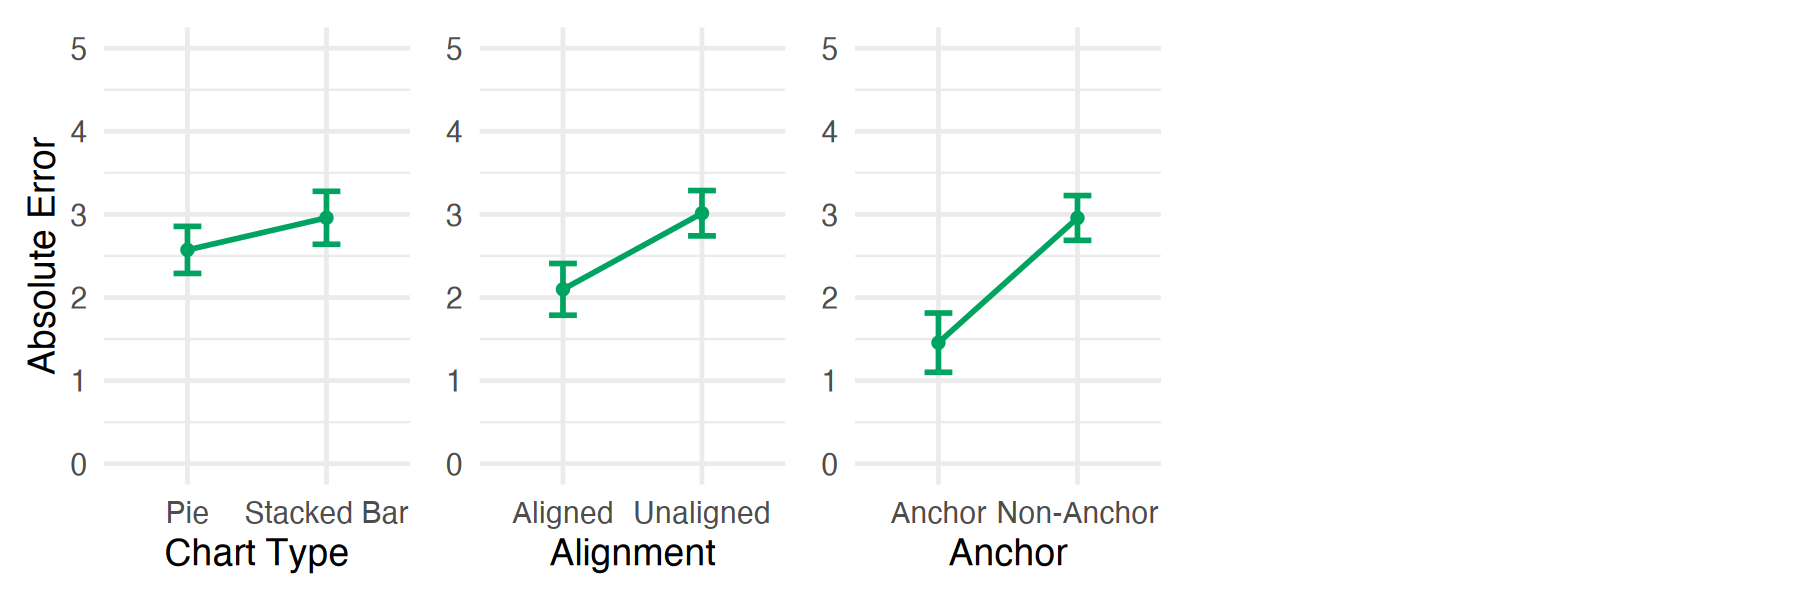

In [12]:

# Generate individual plots
chartTypePlot <- create_error_plot(data, "chartType", "Chart Type", "Absolute Error")
anchorPlot <- create_error_plot(data, "anchor", "Anchor", "Absolute Error")
alignmentPlot <- create_error_plot(data, "alignment", "Alignment", "Absolute Error")

# Set size for the plots
width <- 15
height <- 5
options(repr.plot.width = width, repr.plot.height = height)

# Combine plots with patchwork
full_plot <- chartTypePlot + 
  alignmentPlot + 
  anchorPlot + 
  plot_layout(
    ncol = 4,  # Set the number of columns
    nrow = 1,  # Set the number of rows
    guides = 'collect',  # Collect the legends in a common location
    axis_titles = "collect",  # Collect axis titles
    widths = c(2, 2, 2, 4)  # Adjust relative widths of the plots
  )

# Open SVG device for saving the plot
Cairo::CairoSVG("mainEffects.svg", width = width, height = height)

# Print the combined plot to the SVG device
print(full_plot)

# Close the device
dev.off()

# Optionally display the plot in the notebook
full_plot

In [13]:
# Define the generalized interaction plot function
create_interaction_plot <- function(data, var1, var2, title, y_label, x_label) {

  # Summarize per-user means
  userMeans <- data %>%
    group_by(userID, !!sym(var1), !!sym(var2)) %>%
    summarise(
      meanAbsError = mean(absError, na.rm = TRUE),
      .groups = "drop"
    )

  # Summarize overall means and 95% confidence intervals for interaction
  overallMeans <- userMeans %>%
    group_by(!!sym(var1), !!sym(var2)) %>%
    summarise(
      overallMean = mean(meanAbsError, na.rm = TRUE),
      se = sd(meanAbsError, na.rm = TRUE) / sqrt(n()),
      .groups = "drop"
    ) %>%
    mutate(
      ci_low = overallMean - 1.96 * se,
      ci_high = overallMean + 1.96 * se
    )

  # Create the interaction plot
  plot <- ggplot(overallMeans, aes(x = !!sym(var1), y = overallMean, color = !!sym(var2), group = !!sym(var2))) +
    coord_cartesian(ylim = c(0, 7)) +
    
    # Per-level lines for the interaction
    geom_line(linewidth = 1.2) +
    
    # Points for each level combination
    geom_point(size = 3) +
    
    # 95% Confidence interval error bars
    geom_errorbar(
      aes(ymin = ci_low, ymax = ci_high),
      width = 0.2,  # Control the width of the error bars
      linewidth = 1.2
    ) +
    
    # Customize plot appearance
    theme_minimal(base_size = 14) +
    labs(
      title = title,
      x = x_label,
      y = y_label
    ) +
    scale_color_manual(values = c(blue, red)) # Adjust color scheme if needed

  return(plot)
}

In [14]:
anchorAlignmentPlot <- create_interaction_plot(data, "anchor", "alignment", "Anchor ×\nAlignment", "Absolute Error", "Anchor")
chartAlignmentPlot <- create_interaction_plot(data, "alignment", "chartType", "Chart Type ×\nAlignment", "Absolute Error", "Alignment")
chartAnchorPlot <- create_interaction_plot(data, "anchor", "chartType", "Chart Type ×\Anchor", "Absolute Error", "Anchor")

ERROR: Error: '\A' is an unrecognized escape in character string (<input>:3:87)


pdf 
  2

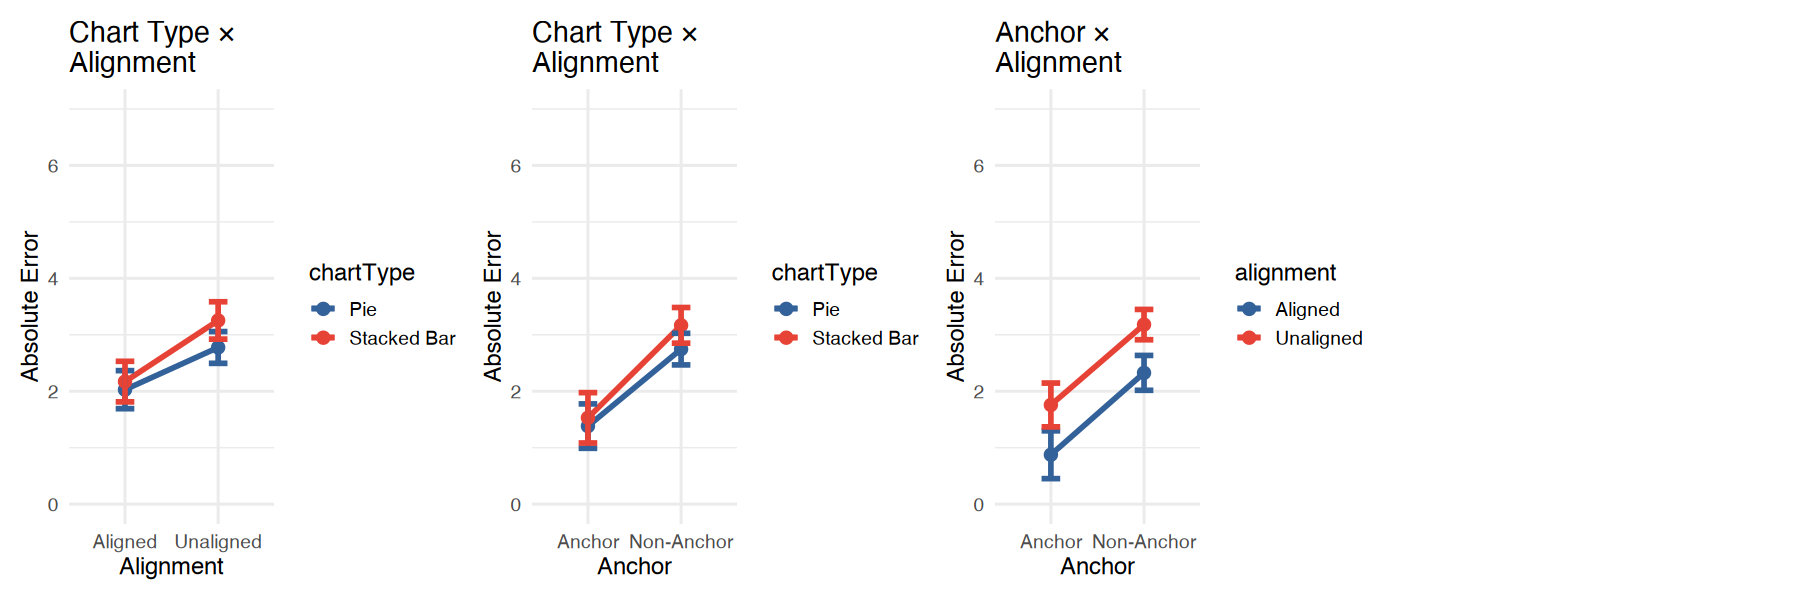

In [ ]:
# Load libraries
library(Cairo)
library(ggplot2)
library(patchwork)

# Set size
width <- 15
height <- 5
options(repr.plot.width = width, repr.plot.height = height)

# Build the full plot
full_plot <- chartAlignmentPlot + 
  chartAnchorPlot + 
  anchorAlignmentPlot + 
  plot_layout(
    ncol = 4,
    nrow = 1,
    widths = c(2, 2, 2, 4)
  )

# Open SVG device
Cairo::CairoSVG("interactions.svg", width = width, height = height)

# Draw plot
print(full_plot)

# Close device
dev.off()

# Display in notebook (optional)
full_plot


In [ ]:
# --- Summarize per-user means by anchorDistance ---
userMeans <- data %>%
  group_by(userID, anchorDistance) %>%
  summarise(
    meanAbsError = mean(absError, na.rm = TRUE),
    .groups = "drop"
  )

# --- Summarize overall means and 95% confidence intervals ---
overallMeans <- userMeans %>%
  group_by(anchorDistance) %>%
  summarise(
    overallMean = mean(meanAbsError, na.rm = TRUE),
    se = sd(meanAbsError, na.rm = TRUE) / sqrt(n()),
    .groups = "drop"
  ) %>%
  mutate(
    ci_low = overallMean - 1.96 * se,
    ci_high = overallMean + 1.96 * se
  )

# --- Reshape for plotting ---
wide_data <- userMeans %>%
  pivot_wider(names_from = anchorDistance, values_from = meanAbsError)

long_data <- wide_data %>%
  pivot_longer(cols = -userID, names_to = "anchorDistance", values_to = "meanAbsError")

# --- Ensure anchorDistance is numeric ---
long_data$anchorDistance <- as.integer(as.character(long_data$anchorDistance))
overallMeans$anchorDistance <- as.integer(as.character(overallMeans$anchorDistance))

# --- Plot ---
anchorDistancePlot <- ggplot(long_data, aes(x = anchorDistance, y = meanAbsError, group = userID)) +
  coord_cartesian(ylim = c(0, 10)) +

  # Per-user trajectories
  geom_line(alpha = 0.2, color = blue) +

  # 95% confidence interval ribbon
  geom_ribbon(
    data = overallMeans,
    aes(x = anchorDistance, ymin = ci_low, ymax = ci_high, group = 1),
    fill = green, alpha = 0.4,
    inherit.aes = FALSE
  ) +

  # Overall mean line and points
  geom_line(
    data = overallMeans,
    aes(x = anchorDistance, y = overallMean, group = 1),
    color = green, linewidth = 1.2,
    inherit.aes = FALSE
  ) +
  geom_point(
    data = overallMeans,
    aes(x = anchorDistance, y = overallMean),
    color = green, size = 3,
    inherit.aes = FALSE
  ) +

  scale_x_continuous(breaks = sort(unique(long_data$anchorDistance))) +  # Make sure ticks show all integer distances
  theme_minimal(base_size = baseSize) +
  labs(
    title = "Anchor Distance",
    x = "Anchor Distance",
    y = "Predicted Mean Absolute Error"
  )

In [ ]:
# --- Summarize per-user means by alignmentDistance ---
userMeans <- data %>%
  group_by(userID, alignmentDistance) %>%
  summarise(
    meanAbsError = mean(absError, na.rm = TRUE),
    .groups = "drop"
  )

# --- Summarize overall means and 95% confidence intervals ---
overallMeans <- userMeans %>%
  group_by(alignmentDistance) %>%
  summarise(
    overallMean = mean(meanAbsError, na.rm = TRUE),
    se = sd(meanAbsError, na.rm = TRUE) / sqrt(n()),
    .groups = "drop"
  ) %>%
  mutate(
    ci_low = overallMean - 1.96 * se,
    ci_high = overallMean + 1.96 * se
  )

# --- Reshape for plotting ---
wide_data <- userMeans %>%
  pivot_wider(names_from = alignmentDistance, values_from = meanAbsError)

long_data <- wide_data %>%
  pivot_longer(cols = -userID, names_to = "alignmentDistance", values_to = "meanAbsError")

# --- Ensure alignmentDistance is numeric ---
long_data$alignmentDistance <- as.integer(as.character(long_data$alignmentDistance))
overallMeans$alignmentDistance <- as.integer(as.character(overallMeans$alignmentDistance))

# --- Plot ---
alignmentDistancePlot <- ggplot(long_data, aes(x = alignmentDistance, y = meanAbsError, group = userID)) +
  coord_cartesian(ylim = c(0, 10)) +

  # Per-user trajectories
  geom_line(alpha = 0.2, color = blue) +

  # 95% confidence interval ribbon
  geom_ribbon(
    data = overallMeans,
    aes(x = alignmentDistance, ymin = ci_low, ymax = ci_high, group = 1),
    fill = green, alpha = 0.4,
    inherit.aes = FALSE
  ) +

  # Overall mean line and points
  geom_line(
    data = overallMeans,
    aes(x = alignmentDistance, y = overallMean, group = 1),
    color = green, linewidth = 1.2,
    inherit.aes = FALSE
  ) +
  geom_point(
    data = overallMeans,
    aes(x = alignmentDistance, y = overallMean),
    color = green, size = 3,
    inherit.aes = FALSE
  ) +

  scale_x_continuous(breaks = sort(unique(long_data$alignmentDistance))) +  # Force all distances to show
  theme_minimal(base_size = baseSize) +
  labs(
    title = "Alignment Distance",
    x = "Alignment Distance",
    y = "Predicted Mean Absolute Error"
  )


Warning message:
“Removed 31 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


pdf 
  2

Warning message:
“Removed 31 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


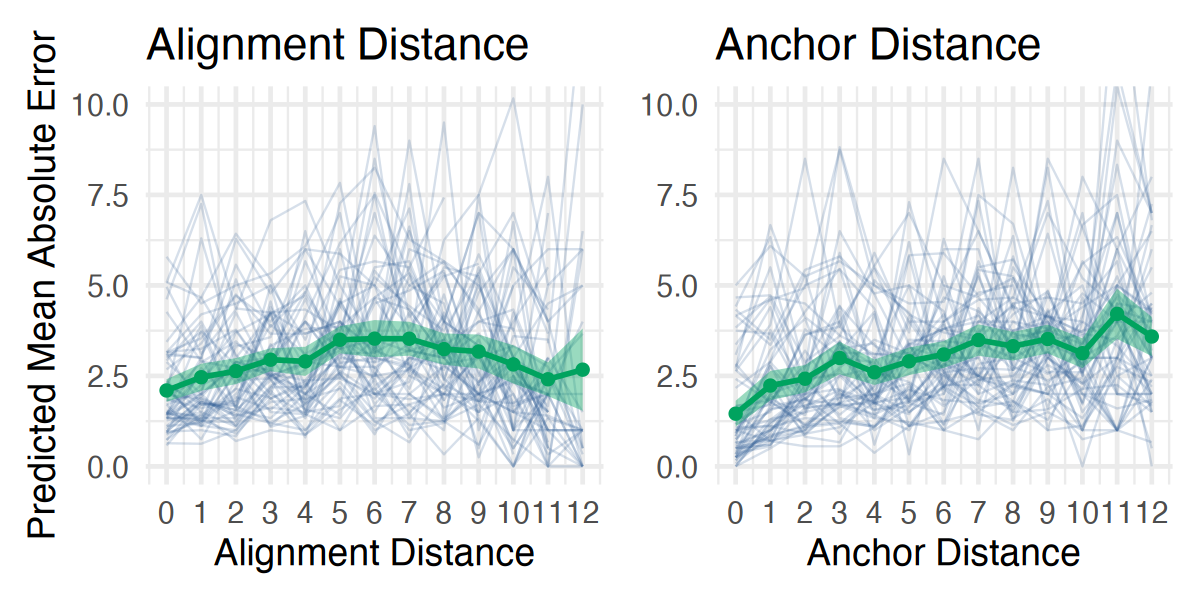

In [ ]:
# Set size
width <- 10
height <- 5
options(repr.plot.width = width, repr.plot.height = height)

# Build the full plot
full_plot <- alignmentDistancePlot + 
  anchorDistancePlot + 
  plot_layout(
    ncol = 2,
    nrow = 1,
    guides = 'collect',
    axis_titles = "collect",
    widths = c(2, 2, 2, 4)
  )

# Open SVG device
Cairo::CairoSVG("distanceplot.svg", width = width, height = height)

# Draw plot
print(full_plot)

# Close device
dev.off()

# Display in notebook (optional)
full_plot


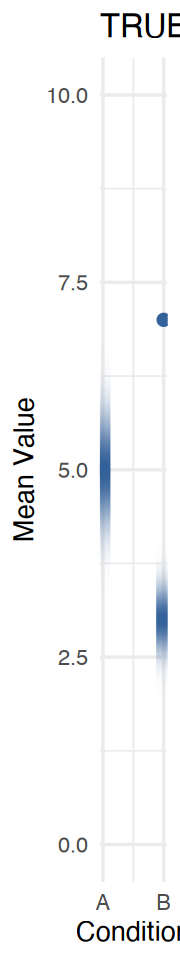

In [ ]:
# Parameters
n_y <- 500  # number of vertical pixels
n_x <- 10   # small width across x

make_vertical_gradient <- function(mean_val, se_val, y_range = c(0, 10), n_y = 500) {
  y_seq <- seq(y_range[1], y_range[2], length.out = n_y)
  alpha_vals <- dnorm(y_seq, mean = mean_val, sd = se_val)
  alpha_vals <- alpha_vals / max(alpha_vals)  # normalize to [0,1]
  
  # Make a matrix: n_y rows, n_x columns
  matrix(rep(alpha_vals, each = n_x), nrow = n_y, byrow = TRUE)
}

library(grid)

create_rasterGrob <- function(alpha_matrix, color = blue) {
  # Create RGB arrays
  rgb_color <- col2rgb(color) / 255
  img <- array(0, dim = c(dim(alpha_matrix), 4))  # 4 channels (RGBA)
  
  img[,,1] <- rgb_color[1]
  img[,,2] <- rgb_color[2]
  img[,,3] <- rgb_color[3]
  img[,,4] <- alpha_matrix  # alpha
  
  # Convert to raster
  rasterGrob(img, interpolate = TRUE)
}

# Example data
means <- data.frame(
  condition = c("A", "B"),
  x = c(1, 2),
  mean = c(5, 7),
  se = c(0.5, 0.3)
)

# Plot
p <- ggplot(means, aes(x = x, y = mean)) +
  geom_point(size = 3, color = blue) +
  scale_x_continuous(breaks = means$x, labels = means$condition) +
  theme_minimal(base_size = 16) +
  labs(
    x = "Condition",
    y = "Mean Value",
    title = "TRUE Smooth Gradient for Means"
  ) +
  coord_cartesian(ylim = c(0, 10))

# Now overlay the raster gradients
for (i in 1:nrow(means)) {
  alpha_mat <- make_vertical_gradient(means$mean[i], means$se[i])
  raster <- create_rasterGrob(alpha_mat, color = blue)
  
  p <- p + annotation_custom(
    raster,
    xmin = means$x[i] - 0.3, xmax = means$x[i] + 0.3,
    ymin = 0, ymax = 10
  )
}

options(repr.plot.width = 1.5, repr.plot.height = 8)
p


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


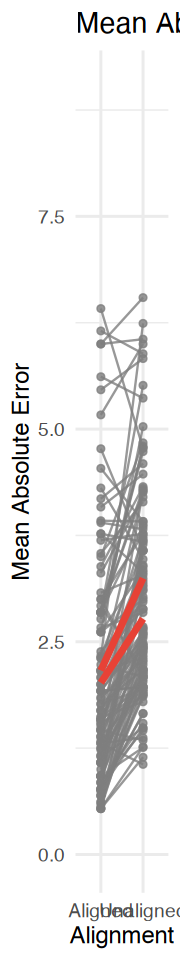

In [ ]:
# Compute userMeans and overallMeans
userMeans <- data %>%
  group_by(userID, alignment, chartType) %>%
  summarise(meanAbsError = mean(absError, na.rm = TRUE), .groups = "drop")

overallMeans <- data %>%
  group_by(alignment, chartType) %>%
  summarise(overallMean = mean(absError, na.rm = TRUE), .groups = "drop")

# Plot
alignmentByChartPlot <- ggplot(userMeans, aes(x = alignment, y = meanAbsError,
                                               group = interaction(userID, chartType),
                                               color = chartType)) +
  coord_cartesian(ylim = c(0, 9)) +
  geom_line(alpha = 0.8) +
  geom_point(alpha = 0.8) +
  # overall mean lines
  geom_line(data = overallMeans,
            aes(x = alignment, y = overallMean, group = chartType),
            linewidth = 1.5,
            inherit.aes = FALSE,
            color = red) +  # pie overall mean in red
  geom_line(data = overallMeans %>% filter(chartType == "line"),
            aes(x = alignment, y = overallMean, group = chartType),
            linewidth = 1.5,
            inherit.aes = FALSE,
            color = blue) +  # line overall mean in blue
  # overall mean points
  geom_point(data = overallMeans %>% filter(chartType == "pie"),
             aes(x = alignment, y = overallMean),
             color = red, size = 3,
             inherit.aes = FALSE) +
  geom_point(data = overallMeans %>% filter(chartType == "line"),
             aes(x = alignment, y = overallMean),
             color = blue, size = 3,
             inherit.aes = FALSE) +
  scale_color_manual(values = c("line" = lightblue, "pie" = lightred)) +
  theme_minimal(base_size = 14) +
  labs(
    title = "Mean Absolute Error per Alignment by Chart Type",
    x = "Alignment",
    y = "Mean Absolute Error",
    color = "Chart Type"
  )

alignmentByChartPlot

In [ ]:
overallMeans

alignment,chartType,overallMean
<fct>,<fct>,<dbl>
Aligned,Pie,2.018397
Aligned,Stacked Bar,2.162943
Unaligned,Pie,2.770132
Unaligned,Stacked Bar,3.246448


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


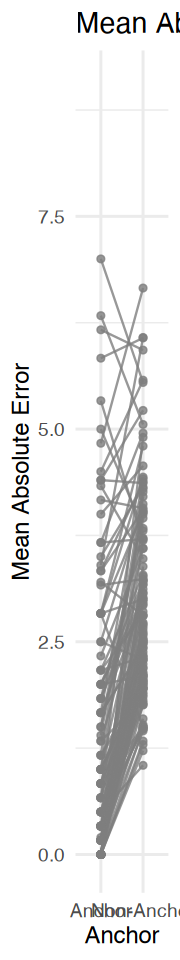

In [ ]:
# Compute userMeans and overallMeans for anchor
userMeansAnchor <- data %>%
  group_by(userID, anchor, chartType) %>%
  summarise(meanAbsError = mean(absError, na.rm = TRUE), .groups = "drop")

overallMeansAnchor <- data %>%
  group_by(anchor, chartType) %>%
  summarise(overallMean = mean(absError, na.rm = TRUE), .groups = "drop")

# Plot
anchorByChartPlot <- ggplot(userMeansAnchor, aes(x = anchor, y = meanAbsError,
                                                  group = interaction(userID, chartType),
                                                  color = chartType)) +
  coord_cartesian(ylim = c(0, 9)) +
  geom_line(alpha = 0.8) +
  geom_point(alpha = 0.8) +
  # overall mean lines
  geom_line(data = overallMeansAnchor %>% filter(chartType == "pie"),
            aes(x = anchor, y = overallMean, group = chartType),
            linewidth = 1.5,
            inherit.aes = FALSE,
            color = red) +
  geom_line(data = overallMeansAnchor %>% filter(chartType == "line"),
            aes(x = anchor, y = overallMean, group = chartType),
            linewidth = 1.5,
            inherit.aes = FALSE,
            color = blue) +
  # overall mean points
  geom_point(data = overallMeansAnchor %>% filter(chartType == "pie"),
             aes(x = anchor, y = overallMean),
             color = red, size = 3,
             inherit.aes = FALSE) +
  geom_point(data = overallMeansAnchor %>% filter(chartType == "line"),
             aes(x = anchor, y = overallMean),
             color = blue, size = 3,
             inherit.aes = FALSE) +
  scale_color_manual(values = c("line" = lightblue, "pie" = lightred)) +
  theme_minimal(base_size = 14) +
  labs(
    title = "Mean Absolute Error per Anchor by Chart Type",
    x = "Anchor",
    y = "Mean Absolute Error",
    color = "Chart Type"
  )

anchorByChartPlot
